In [65]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.dates as mdates
import os
import sys

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_squared_error

from utils.metrics import predicted_revenue

import warnings

from data.data_loader import Dataset_ARIMA
from torch.utils.data import Dataset
from utils.tools import StandardScaler, MinMaxScaler
from utils.timefeatures import time_features

In [110]:
class Dataset_Analysis(Dataset):
    
    def __init__(self, root_path='data\processed\SRL', train_val_test_split = [0.7, 0.15, 0.15],
                 data_path=None, 
                 data_name='SRL_NEG_00_04', target='capacity_price', scale='standard', cols=None):
        
        
        self.scale = scale
        self.root_path = root_path
        if data_path is not None:  
            self.data_path = data_path
        else: self.data_path = ''.join((data_name, '.csv'))
        self.data_name = data_name
        self.target = target
        self.train_val_test_split = train_val_test_split
        self.__read_data__()
        
    def __read_data__(self):
        
        if self.scale == 'minmax':
            self.scaler = MinMaxScaler()
          
        elif self.scale == 'standard':
            self.scaler = StandardScaler()
        
        elif self.scale is None:
            self.scaler = None
            
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                                self.data_path))        
        df_data = df_raw[[self.target]]
        self.data = df_data.values.squeeze()
    
        self.date = np.array(df_raw['date'].values, dtype='datetime64')
        
    def plot_ts(self, figsize=(13,5), savefig=False):
        # Prepare the figure
        fig, ax = plt.subplots(figsize=figsize)


        # Plot the test data
        ax.plot(self.date, self.data)

        # Format the x-axis to only show the first day of each month
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # Set the y-axis limits
        ax.set_ylim([0, np.percentile(self.data, 97.5)])

        # Rotate the date labels to avoid overlap
        fig.autofmt_xdate()

        # Add title and labels
        ax.set_title(f"Product {self.data_name} from {self.date[0]} to {self.date[-1]}")
        ax.set_xlabel("Date [Y-m-d]")
        ax.set_ylabel("Capacity price (€)")

        if savefig:
            fig.savefig(f'img/plot_ts_{self.data_name}.jpg', bbox_inches='tight')
            
        return fig
    
    def decomposition(self, figsize=(12,7), savefig=False):

        # Create a pandas DataFrame from the data
        data = pd.DataFrame({'Date': self.date, 'Value': self.data})

        # Perform time series decomposition using pandas (seasonal decomposition of time series)
        # Perform time series decomposition using statsmodels
        decomposition = sm.tsa.seasonal_decompose(data.set_index('Date')['Value'], model='additive', period=7)

        # Access the decomposed components: trend, seasonal, and residual
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        # Plot the original data and the decomposed components
        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[2, 1, 1, 1]) 
        
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        ax3 = plt.subplot(gs[2])
        ax4 = plt.subplot(gs[3])
                
        # plt.subplot(4, 1, 1)
        ax1.plot(data['Date'], data['Value'], label='Original')
        # ax1.set_ylim([0, np.percentile(data['Value'], 97.5)])
        ax1.legend(loc='upper left')

        # plt.subplot(4, 1, 2)
        ax2.plot(trend, label='Trend')
        ax2.legend(loc='upper left')

        # plt.subplot(4, 1, 3)
        ax3.plot(seasonal, label='Seasonal')
        ax3.legend(loc='upper left')

        # plt.subplot(4, 1, 4)
        ax4.plot(residual, label='Residual')
        ax4.legend(loc='upper left')
        
        # Set the y-axis limits

        if savefig:
            fig.savefig(f'img/plot_decomp_{self.data_name}.jpg', bbox_inches='tight')
            
        plt.tight_layout()
        return fig

Product names

Code: 'product_names = [name.split('.')[0] for name in os.listdir("data/processed/SRL/")[1:]]'

['SRL_NEG_00_04', 'SRL_NEG_04_08', 'SRL_NEG_08_12',
 'SRL_NEG_12_16', 'SRL_NEG_16_20', 'SRL_NEG_20_24',
 'SRL_POS_00_04', 'SRL_POS_04_08', 'SRL_POS_08_12',
 'SRL_POS_12_16', 'SRL_POS_16_20', 'SRL_POS_20_24']

In [117]:
product_names = ['SRL_NEG_00_04', 'SRL_NEG_04_08', 'SRL_NEG_08_12',
 'SRL_NEG_12_16', 'SRL_NEG_16_20', 'SRL_NEG_20_24',
 'SRL_POS_00_04', 'SRL_POS_04_08', 'SRL_POS_08_12',
 'SRL_POS_12_16', 'SRL_POS_16_20', 'SRL_POS_20_24']

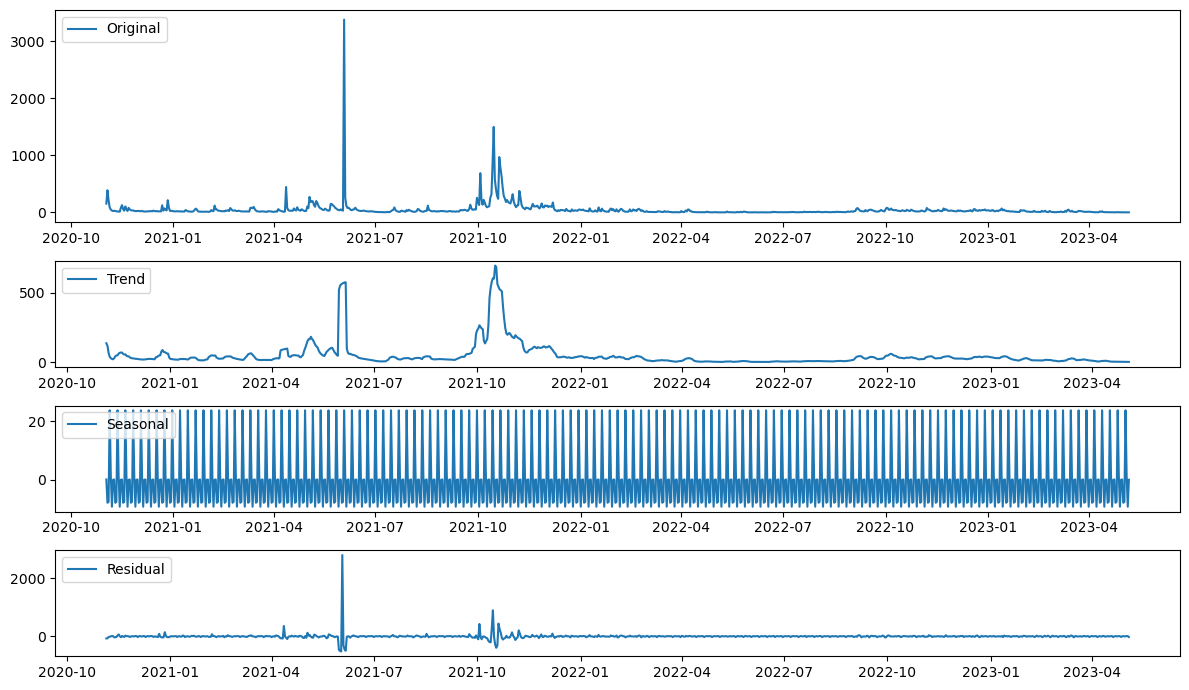

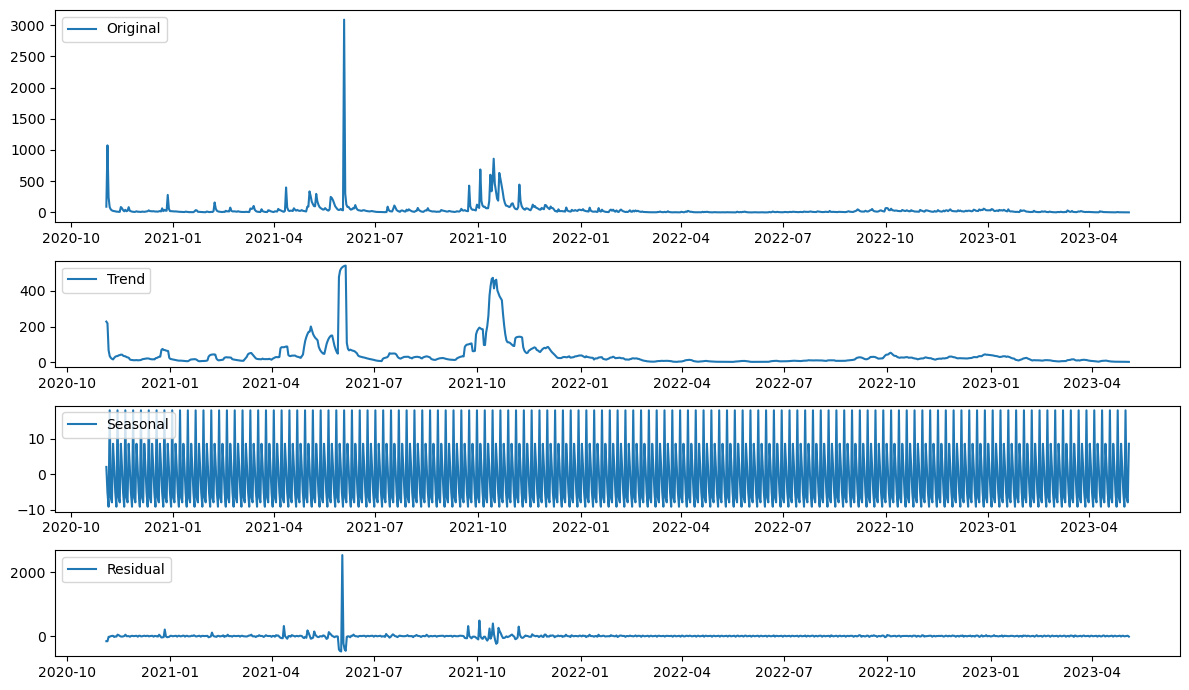

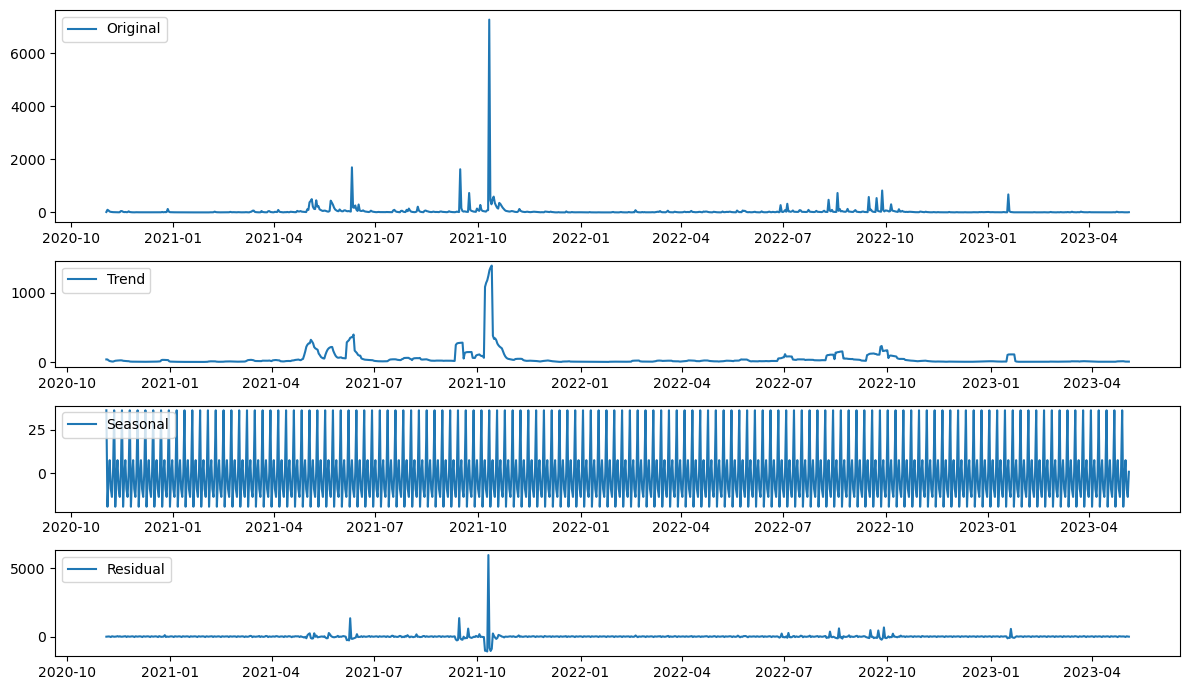

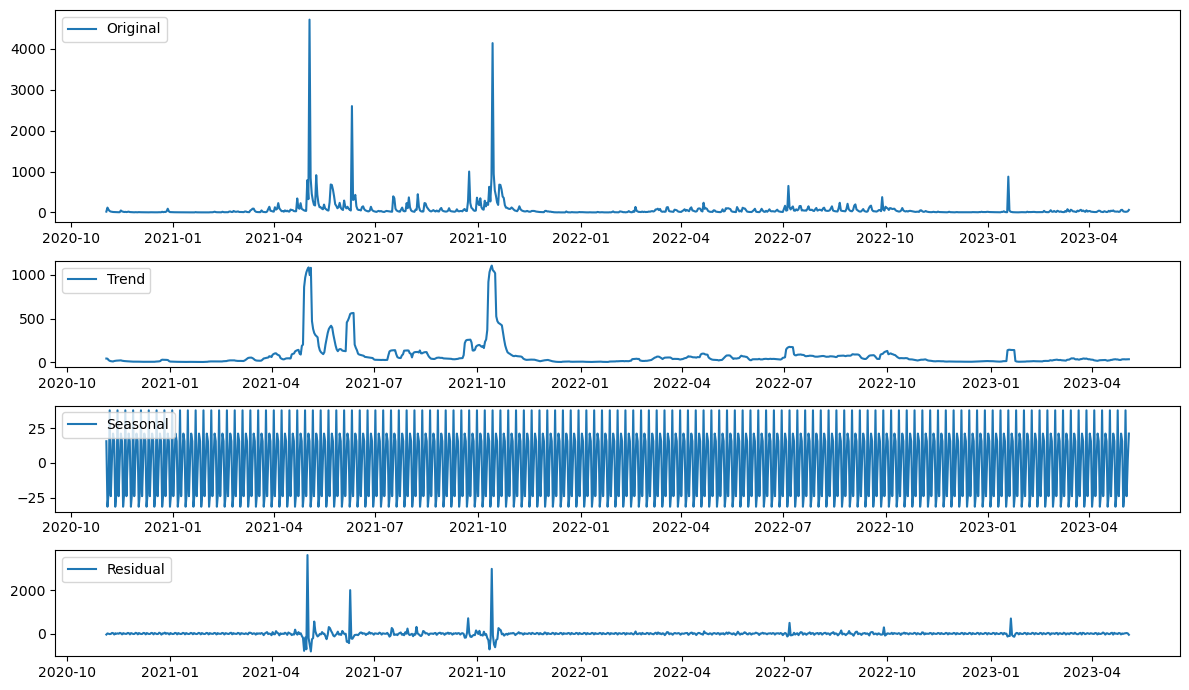

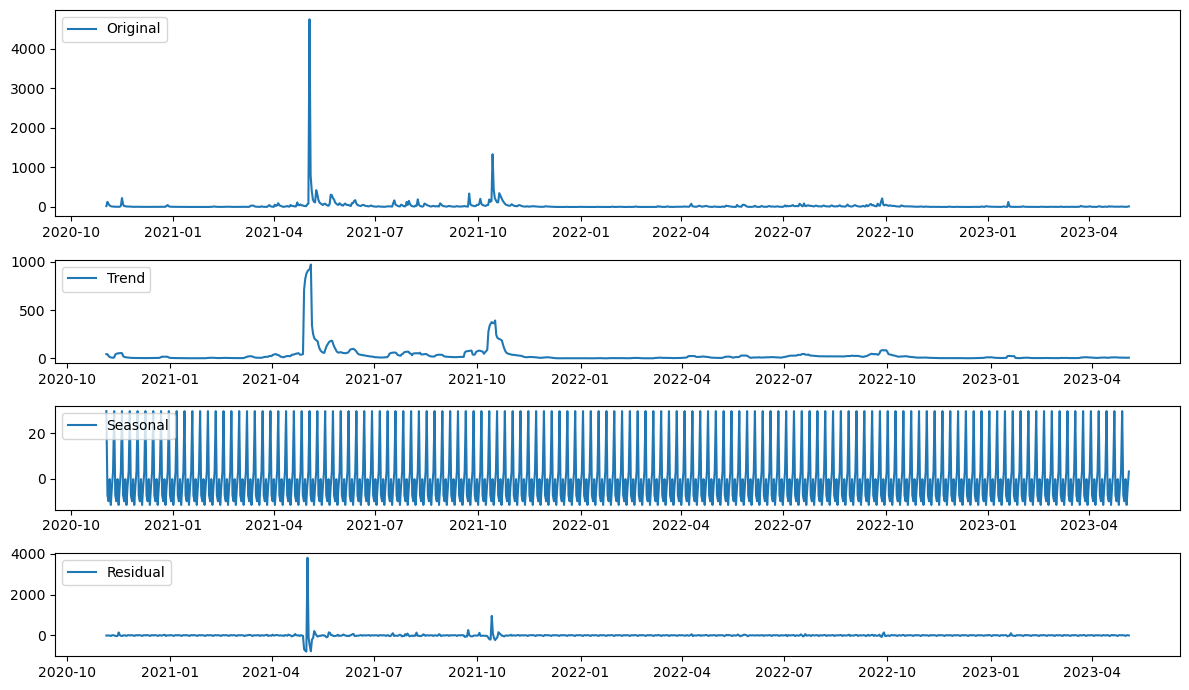

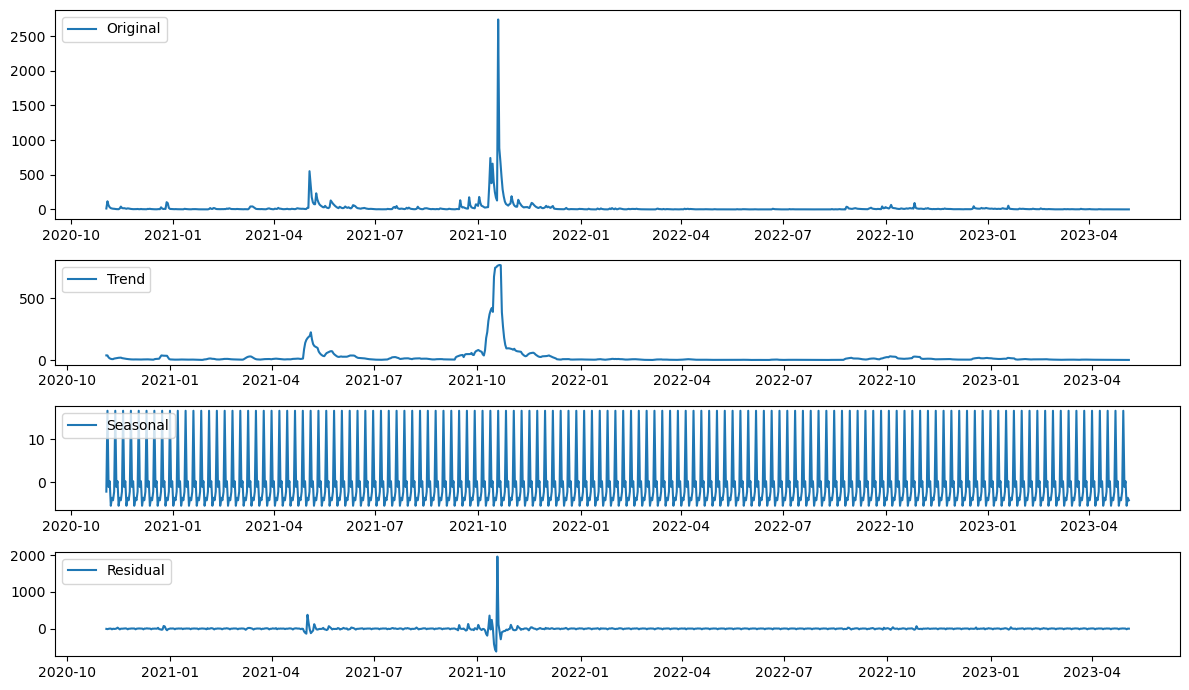

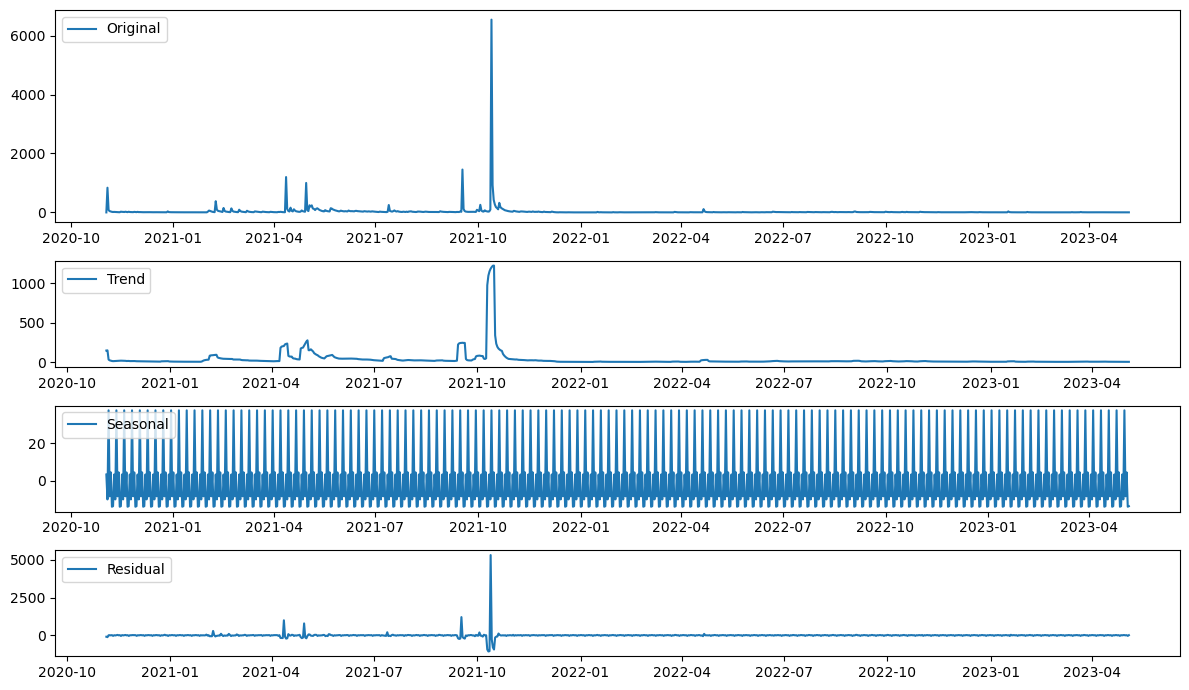

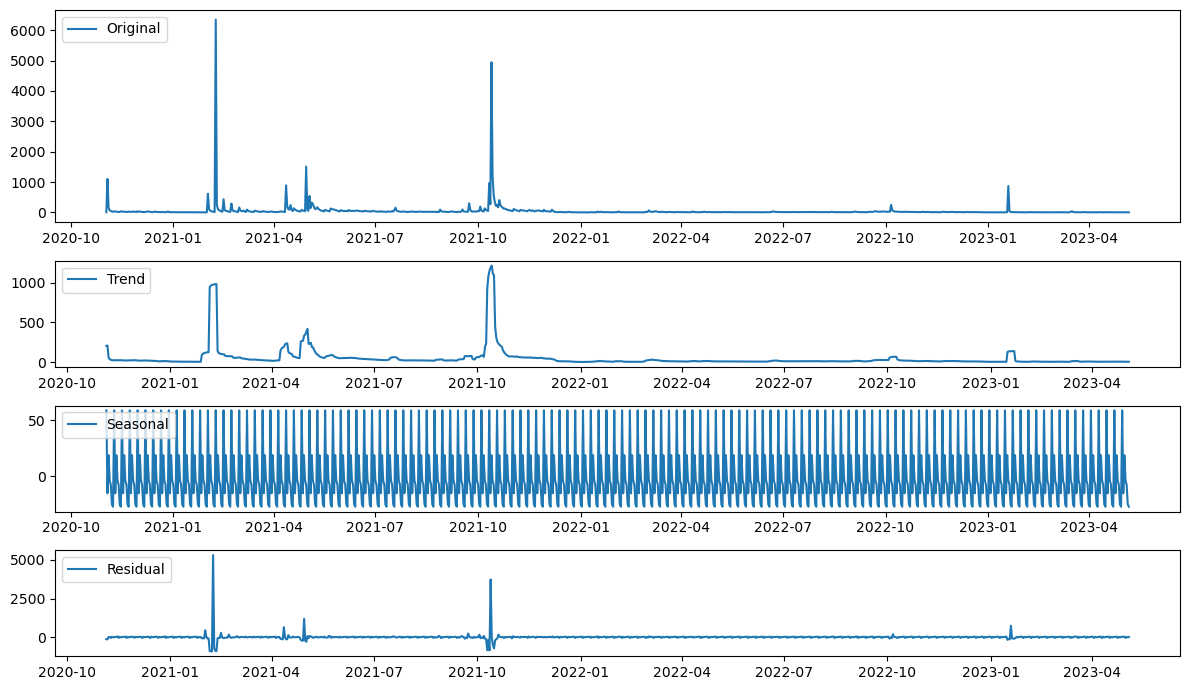

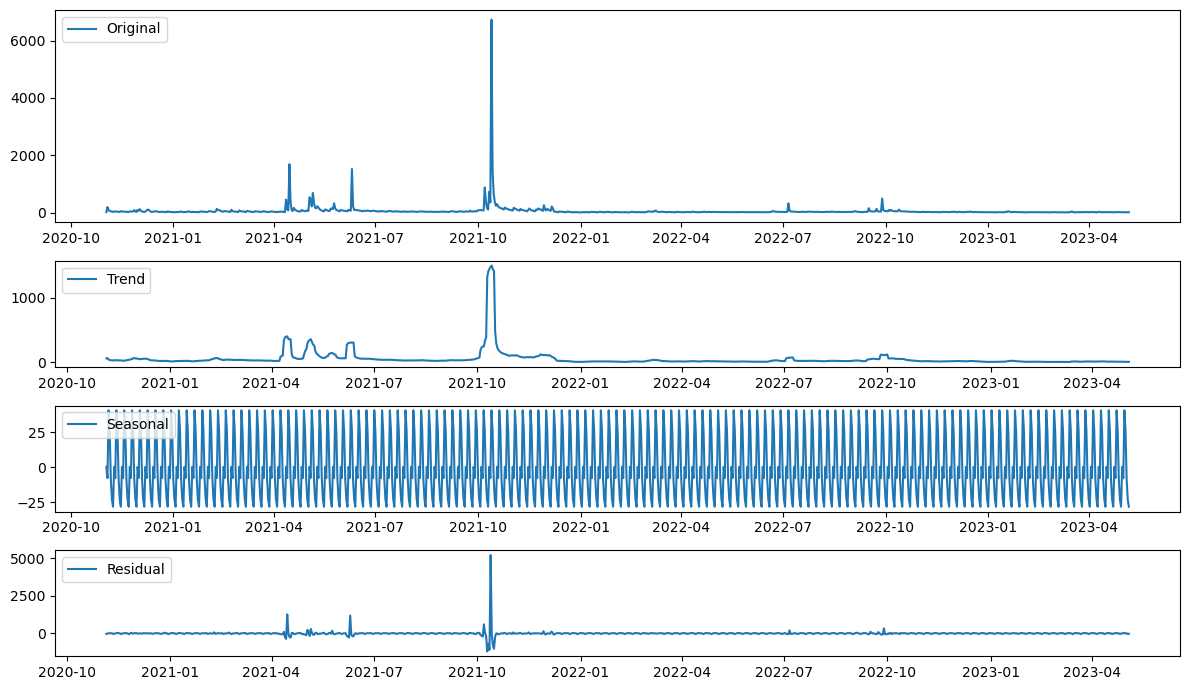

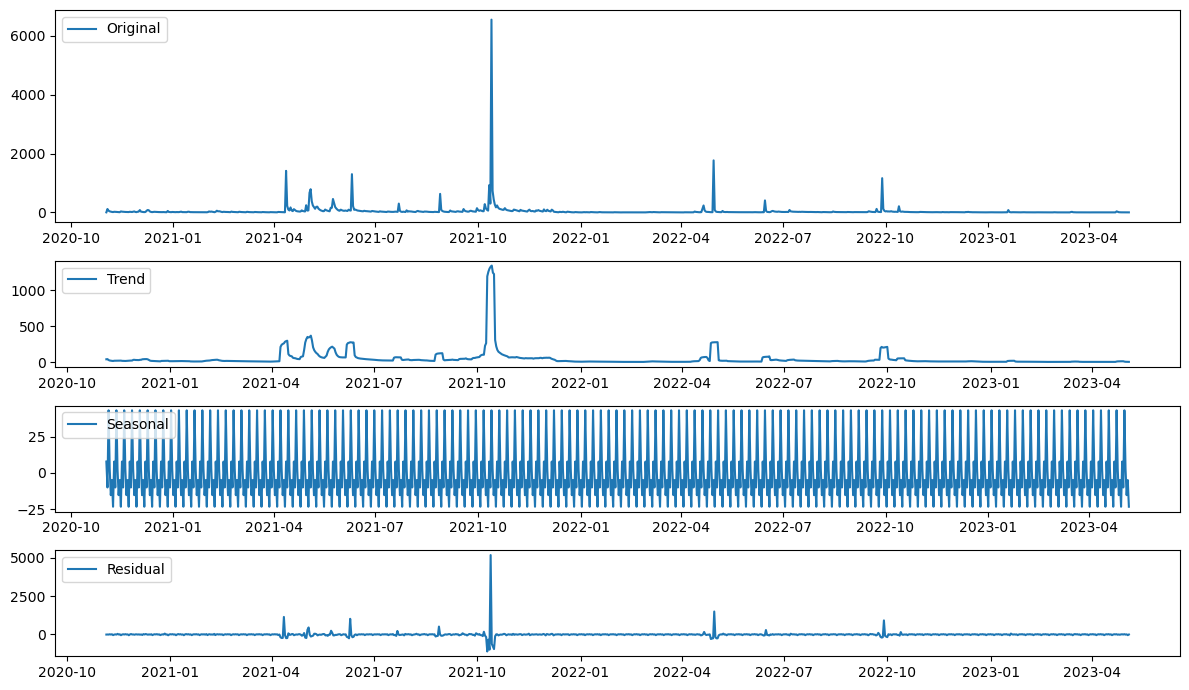

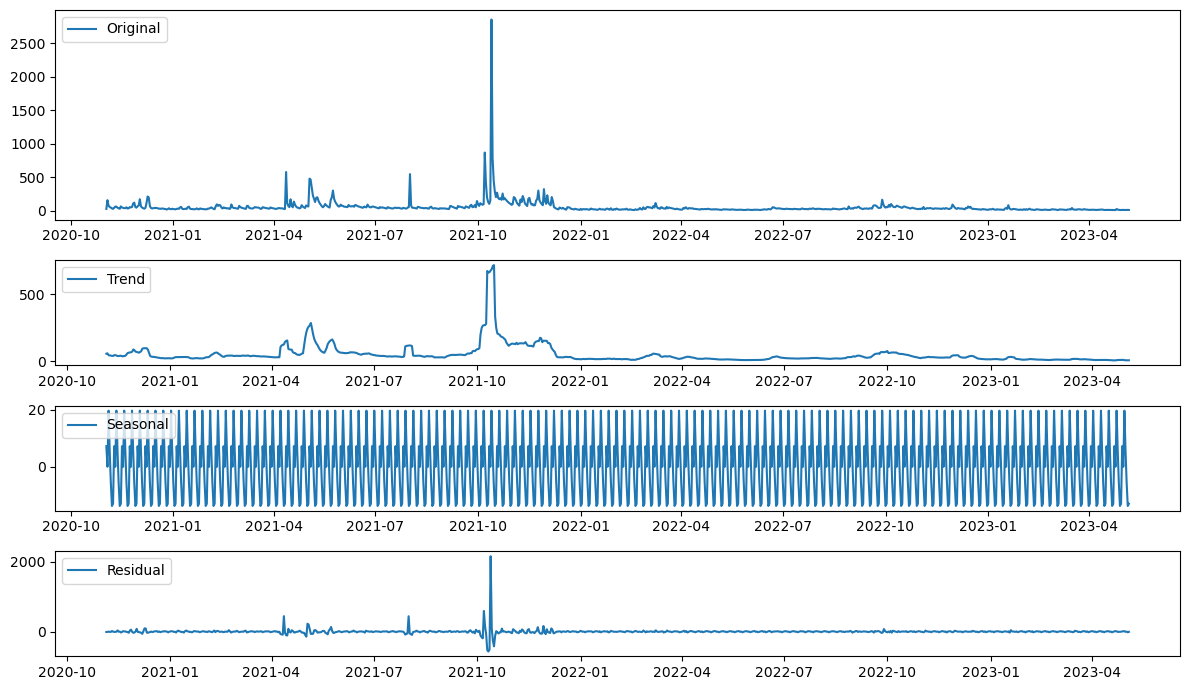

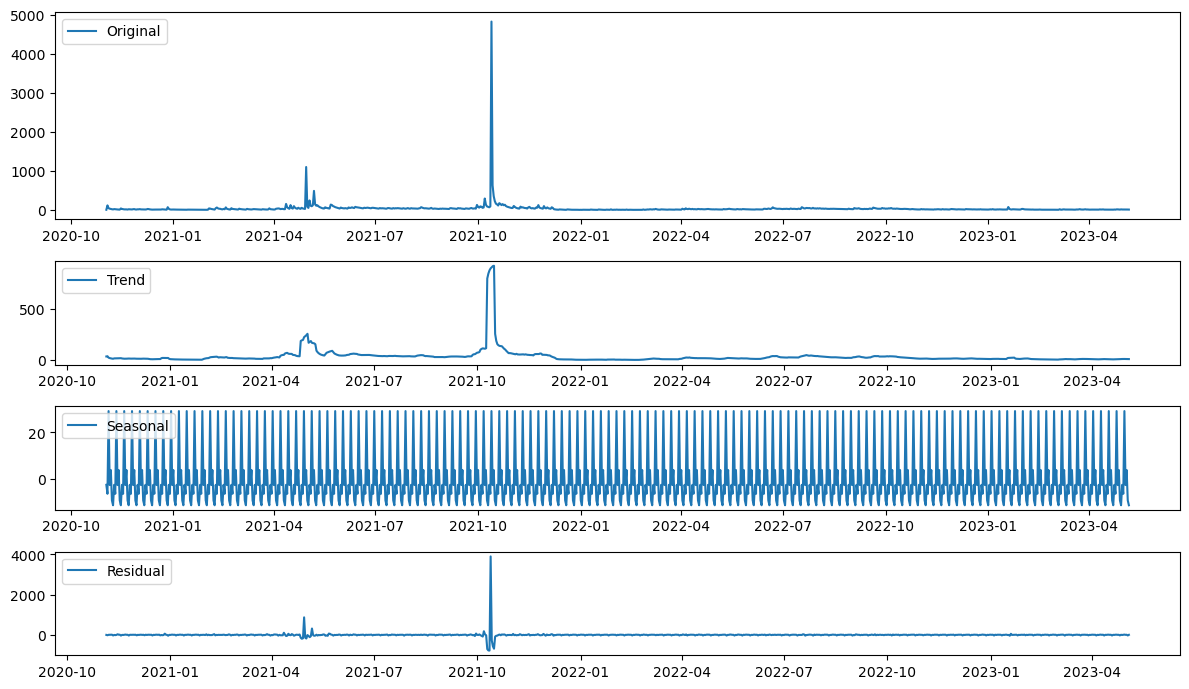

In [118]:
for product in product_names:
    data = Dataset_Analysis(data_name=product)
    data.decomposition(savefig=True)

In [ ]:
for product in product_names:
    data = Dataset_Analysis(data_name=product)
    data.decomposition(savefig=True)